<a href="https://colab.research.google.com/github/greyxray/mbd_research_notebooks/blob/main/causal_inference_personalizing_discounts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Causal Inference: Personalizing Discounts

Source: https://www.manning.com/liveproject/personalizing-discounts

An E-commerce wishes to use discounts to boost sales and hence, profits. But while discounting does boost sales, in the long run, it has a direct negative impact on profits: whatever you give as a discount you don't make as earnings.

The e-commerce company states that each customer's profitability is given as follows:

>  $Profits_i = Sales_i * 0.05 -Discount_i$

So they need to figure out whether discounting boosts sales by a high enough amount to compensate for the direct loss in revenues caused by giving discounts. Notice how they are not interested in predicting profits. Rather, **they wish to know the causal impact of discount on profits. If it's positive, then discounting is worth it.**



The easiest way to answer this question would be to use a randomized controlled trial (RCT), also called A/B testing. We would give discounts at random and compare the profitability of those that got high discounts against that of those who got low discounts

With personalization we want to recognize that some customers can respond better to discounting than others. Once we do that, the task becomes finding the customers that are positively impacted by discounts.

**The idea is that even if discounting is not very promising on average, it might still be profitable if we do it for a targeted group of customers.**

## TL:DR
The aim of this project is to use causal inference to investigate data on randomized discounts and determine if an e-commerce company should offer personalized discounting.
We want to:

* Estimate a different treatment effect for each customer in the hopes to see if some are positive
* Figure out which customers should get high discounts.


## Imports

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving non_rand_discount.csv to non_rand_discount.csv
Saving random_data.csv to random_data.csv


In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score

# Dataset
The first file, non_rand_discount.csv, contains historical data from an e-commerce company. In this dataset, the discount was not randomly assigned. The second file, random_data.csv, contains data where the discount was randomly assigned.

We use nonexperimental data to estimate our models (training data) and save all the experimental data for validation purposes (test data).



In [ ]:
import io
df_rand = pd.read_csv(io.BytesIO(uploaded['random_data.csv']))
df_non_rand = pd.read_csv(io.BytesIO(uploaded['non_rand_discount.csv']), sep = ';')


In [ ]:
print( f'Randomly assigned dscts data: {df_rand.shape}')
print( f'Not rand assigned dscts data: {df_non_rand.shape}')

Randomly assigned dscts data: (5000, 43)
Not rand assigned dscts data: (15000, 45)


In [ ]:
df_non_rand.columns

Index(['spend_1m_baby', 'spend_2m_baby', 'spend_3m_baby', 'spend_4m_baby',
       'spend_5m_baby', 'spend_6m_baby', 'spend_1m_clothes',
       'spend_2m_clothes', 'spend_3m_clothes', 'spend_4m_clothes',
       'spend_5m_clothes', 'spend_6m_clothes', 'spend_1m_health',
       'spend_2m_health', 'spend_3m_health', 'spend_4m_health',
       'spend_5m_health', 'spend_6m_health', 'spend_1m_pet', 'spend_2m_pet',
       'spend_3m_pet', 'spend_4m_pet', 'spend_5m_pet', 'spend_6m_pet',
       'spend_1m_groceries', 'spend_2m_groceries', 'spend_3m_groceries',
       'spend_4m_groceries', 'spend_5m_groceries', 'spend_6m_groceries',
       'spend_1m_eletronic', 'spend_2m_eletronic', 'spend_3m_eletronic',
       'spend_4m_eletronic', 'spend_5m_eletronic', 'spend_6m_eletronic',
       'sales', 'discount', 'profit', 'age', 'gender', 'cust_state', 'tenure',
       'sales_prediction_bins', 'sales_prediction'],
      dtype='object')

The *xm* columns represent the total spend in the last x months for that category. Categories: baby, clothes, health, pet, groceries, electronic.

**sales**: long-term sales for that customer – this is a possible outcome variable; it should not be used as a feature

**discount**: amount of discount given to the customer at the moment they joined the platform

**profit**: long-term profit for that customer – profit is given by the formula 5% sales - discount

**cust_state**: customer address state – last address used for delivery – provided at customer onboarding stage

**tenure**: time since customer joined the platform in months

**sales_prediction_bins**: discretization of the machine learning model's score

**sales_prediction**: machine learning model's score.

*random_data  does not have the sales_prediction_bins and sales_prediction columns.*

# Average Treatment Effect


The average treatment effect (ATE) measures how well the customers respond to discounting on average.
So say the ATE is, for example, 10, meaning that profits increase 10 units for each additional unit of discount. This does not mean all customers have a treatment effect (TE) of 10. Some might have a TE of 15, or -5, or 20. But when we average all these effects, we get 10.


The average treatment effect (ATE) is a measure used to compare treatments (or interventions) in randomized experiments, evaluation of policy interventions, and medical trials. The ATE measures the difference in mean (average) outcomes between units assigned to the treatment and units assigned to the control

In [ ]:
train = df_non_rand
test = df_rand

In [ ]:
train["discount"] = train["discount"].str.split(" ").str[-1].astype(float)

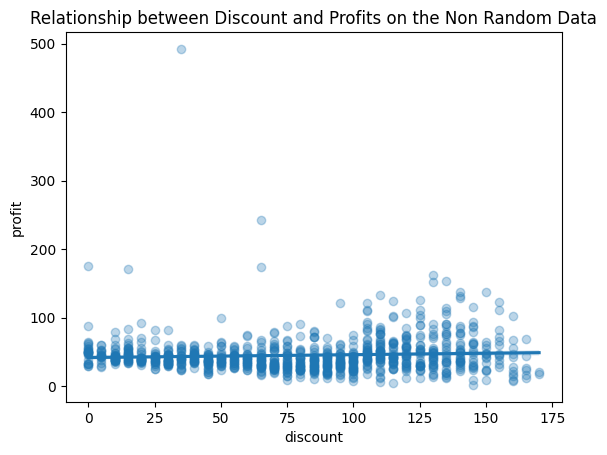

In [ ]:
np.random.seed(123)
sns.regplot(data = train.sample(1000), x="discount", y="profit", scatter_kws={"alpha":0.3})
plt.title("Relationship between Discount and Profits on the Non Random Data");

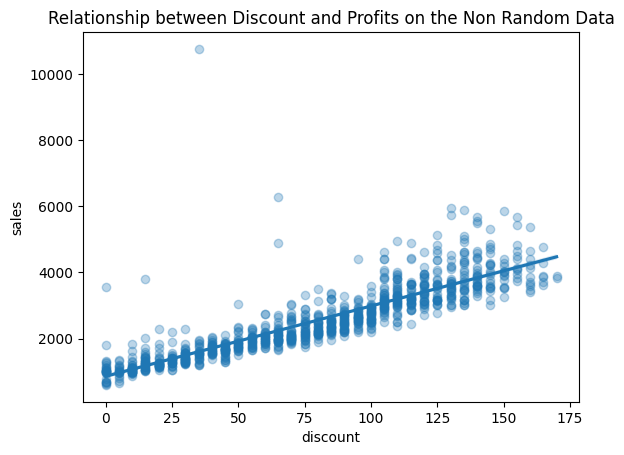

In [ ]:
np.random.seed(123)
sns.regplot(data = train.sample(1000), x="discount", y="sales", scatter_kws={"alpha":0.3})
plt.title("Relationship between Discount and Profits on the Non Random Data");

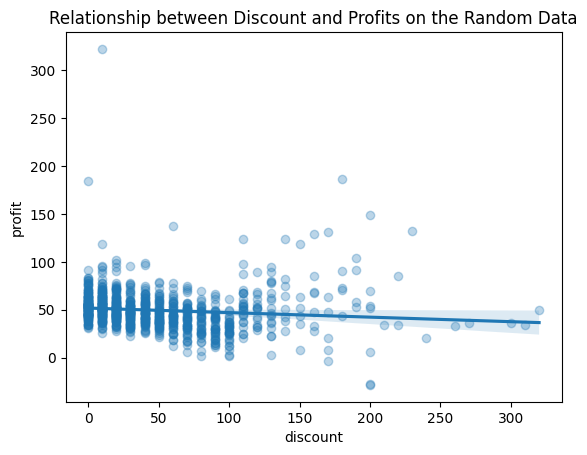

In [ ]:
np.random.seed(123) # for reproducibility
sns.regplot(data = test.sample(1000), x="discount", y="profit", scatter_kws={"alpha":0.3})
plt.title("Relationship between Discount and Profits on the Random Data");

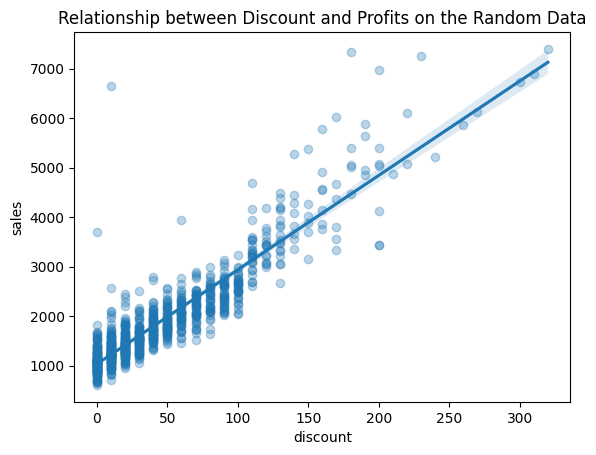

In [ ]:
np.random.seed(123)
sns.regplot(data = test.sample(1000), x="discount", y="sales", scatter_kws={"alpha":0.3})
plt.title("Relationship between Discount and Profits on the Random Data");

The first plot shows a positive relationship between discount and profits. We cannot say this relationship is causal, because there might be confounding variables that were unaccounted for.

As for the second plot, it shows a negative relationship between discount and profits. Since discount was randomly assigned in this dataset, we can say that this relationship captures the causal effect of discount on profits.

Estimating the ATE by estimating the slope coeffiient of a regression line of the outcome on treatment. Linear causal effect: Cov (T,Y)/ Var (T).

On the randomized set:

In [ ]:
def elast(data, t, y):
    cov_matrix = np.cov(data[y], data[t])
    return cov_matrix[1, 0] / cov_matrix[1, 1]

In [ ]:
print("ATE of discount on sales:", elast(test, "discount", "sales"))
print("ATE of discount on profit:", elast(test, "discount", "profit"))

ATE of discount on sales: 19.286765416028715
ATE of discount on profit: -0.03566112670736013


On the not randomized set:

In [ ]:
print("Relationship between discount on sales:", elast(train, "discount", "sales"))
print("Relationship between discount on profit:", elast(train, "discount", "profit"))

Relationship between discount on sales: 21.924806313467585
Relationship between discount on profit: 0.07431475005627178


Looking at the regression coefficient between discount and sales on the data where discounts was randomly assigned, we can see that one unit of discount increases sales by about 19.28. From the introduction of this project, we know that profit is given by

$$
Profit_i = Sales_i * 5\% - Discount_i
$$

This means that, in order to increase profitability, 1 unit of discount has to increase sales by at more than 20 units ($1/0.05 = 20$). Since that doesn't happen (even though by little) discounting becomes an unprofitable business.

As for the relationship we see in the data where discount was not randomly assigned, we can't attribute a causal meaning to it. At least not before considering the forms in which it can be biased,

In [ ]:
# run a regression of profits on discount
smf.ols("profit~discount", data=test).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,51.3226,0.390,131.725,0.000,50.559,52.086
discount,-0.0357,0.006,-6.058,0.000,-0.047,-0.024


The coefficient from the univariate regression model matches \\(Cov(t, y)/Var(t)\\). If we look at the confidence interval, we can see it does not contain zero. Hence, **the effect of discount on profitability is negative** and statistically significant.  Not produced by chance.
DIscount is not profitable in average


# how we can still make a profit from a treatment (discount) that is not profitable on average?



 what does it means for a discount to have a negative impact on profits, on average?. Hidden in this statement is the fact that each individual customer has its own effect. In other words, **each customer responds differently to discounts**. We can think about this as multiple hidden lines, one for each customer, showing how profit changes as a function of discount.

We wish to separate customers with negative causal effect from those with positive causal effect. Once we have that, we will give a discount only to customers with a positive effect

Usually when companies approach a problem like this, they think about machine learning. A common first approach is to train a model to predict sales and use the predictions from this model to personalize the distribution of discounts, maybe by giving more discounts to customers with high sales predictions, maybe by giving more discounts to customers with low sales predictions. There usually isn’t a clear formalization on why that should work, but let’s try it. The first approach will serve as a benchmark that we will compare against in the future.

## Predicting sales

Using  LGBMRegressor, we fit a model that predicts sales. we use only in the train dataset (nonrandomized data), randomized data hidden for validation purposes.

In [ ]:

X = list(train.drop(columns=['sales', 'profit', "cust_state", "discount", "sales_prediction_bins", "sales_prediction"]).columns)
#removing discounts because, in theory, we don't know the discount level we will give before making sales predictions
Y = "sales"


In [ ]:
np.random.seed(123)
pred_m = LGBMRegressor(max_depth=3)
pred_m.fit(train[X], train[Y])

LGBMRegressor(max_depth=3)

In [ ]:
train_pred = train.assign(prediction = pred_m.predict(train[X]))
test_pred = test.assign(prediction = pred_m.predict(test[X]))

#Evaluating performance
print("Train Score:", r2_score(train_pred["sales"], train_pred["prediction"]))
print("Test Score:", r2_score(test_pred["sales"], test_pred["prediction"]))

Train Score: 0.8542367421768512
Test Score: 0.42184459036355626


Both train and test set have decent performance. While there is clearly a gap between training and test performance, that is probably due to different discount regimes and not a case of overfitting. Once again, we are not particularly interested in predictive performance here. This is mostly to confirm that the model is not completely off.

**We wish to segment customers according to their responsiveness to treatment. **

We want to use this model for personalization. For it to be useful for personalizing discounts, customers with high sales predictions should respond differently to discounting compared to customers with low sales predictions.

**these models should segment customers according to their responsiveness to the treatment.**

In [ ]:
#sorting by sales prediction
sorted_by_pred_test = test_pred.sort_values("prediction", ascending=False)

sorted_by_pred_test[["prediction", "profit", "discount"]].head()

,prediction,profit,discount
2913,8410.140425,389.76,150.0
1736,7171.388857,295.87,300.0
646,6496.265942,322.49,10.0
4354,6404.367544,186.96,180.0
1689,6375.683350,165.58,180.0


Using the elast function , estimate the elasticity on the top 1k customers with higher sales predictions. This is called the **conditional average treatment effect** (CATE), because we are conditioning the treatment effect on the sales prediction:

E[Y_1 - Y_0 | SalesPred>x]


 How does the elasticity differ in the top 1k and last 1k custoers? Are discounts profitable in any of them?

In [ ]:
print("CATE top 1k:", elast(sorted_by_pred_test.head(1000), "discount", "profit"))
print("CATE botom 1k:", elast(sorted_by_pred_test.tail(1000), "discount", "profit"))

CATE top 1k: -0.09637736244794491
CATE botom 1k: -0.29111205551220626


This means that, first, discounts are **not** profitable in any segment defined by sales predictions. Second, the higher the sales prediction, the **less sensitive customer's profit are to discount**. That is, the lower the sales prediction, the more discount impacts profits in a negative way.

# Treatment effect heterogeneity

Some researchers call a treatment effect "heterogenous" if it affects different individuals differently (heterogeneously).

One way to look for heterogeneous treatment effects is to divide the study data into subgroups  and see if the average treatment effects are different by subgroup. A per-subgroup ATE is called a "conditional average treatment effect" (CATE). (depends on the amount of data for each subgroup)


Evaluating Personalization Strategies
come up with some validation techniques to evaluate how good this model is for such a personalization task.

What does it means to have a good personalization model/strategy? Some bad ones?

How can we evaluate it?


if we think about what some awful ones are. Let’s think about using a random number generator as a personalization strategy. We randomly pick a number between 0 and 1. The higher the number, the greater the discount we give.
The difference between treatment and control groups is constant across groups. In other words, there is no treatment effect heterogeneity

**a great personalization strategy will find some way to segment the customers in such a way that they respond very differently to the treatment in each segment**.

We would like to give  discounts only to customers in segment 1, with a positive treatment effect. More generally, in personalization, we want groups with different treatment effects. This means we need to craft evaluation techniques that translate this desire of ours, which is precisely what we will do in this milestone.

### Binary treatment

In [ ]:
#Since we are simplifying the problem by making the treatment binary, let’s first write some code to account for that simplification.
# This column should be 1 if the discount column is greater than 30 and 0 otherwise.
test_pred["binary_discount"] = np.where(test_pred["discount"] > 30, 1, 0)

In [ ]:
#treatment effect avg(outcome|T=1) - avg(outcome|T=0).
def te(df, t, y):
    return df.query(f"{t}==1")[y].mean() - df.query(f"{t}==0")[y].mean()

In [ ]:
#compute treatment effect
ate = te(test_pred, y="profit", t="binary_discount")
ate

-7.955100647304356

The average treatment effect is -8, which means that, if we treat everyone in the test set, we should expect our profits to go down by 8 per customer.

### Build a treatment effect by band plot to evaluate our model

In [ ]:
# This function should define the segments as the quantiles of a column. For example, if you want to segment your data by age,
# create a new column that contains the age quantiles.

def te_by_segment(df, pred, t, y, segments=10):
    return (df
            .assign(**{f"{pred}_band":pd.qcut(df[pred], q=segments)}) # makes quantile segments
            .groupby(f"{pred}_band")
            .apply(lambda df: te(df, y=y, t=t))) # estimate the treatment effect on each segment

If we segment the customers by our **sales prediction model**, we can see that, first, there is no segment where more discounts leads to more profit, since the treatment effect is always negative.

Now, take a look at the **age segments**. First thing we notice is that there is an age segment where discounts are profitable. If we look at segment (40 to 67), the effect of discounts is to increase profits by about 4. This means that, if we segment customers by age, we can find segments where discounts are profitable, something we cannot find with sales prediction segments.

Finally, once we **segment by a random number**, we can see that the treatment effect varies around the average treatment effect, which we found to be about -8. This is expected, since each segment defined by the random number should behave like a representative sample of the entire test set.

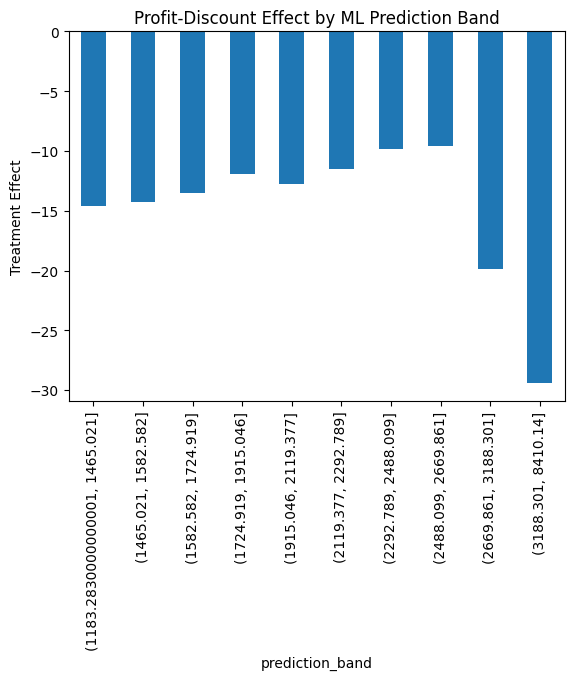

In [ ]:
(te_by_segment(test_pred, "prediction", y="profit", t="binary_discount", segments=10)
 .plot.bar(title="Profit-Discount Effect by ML Prediction Band"))
plt.ylabel("Treatment Effect");

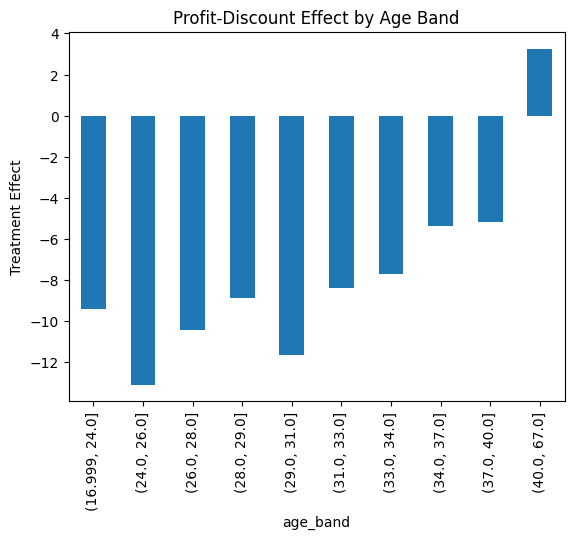

In [ ]:
(te_by_segment(test_pred, "age", y="profit", t="binary_discount", segments=10)
 .plot.bar(title="Profit-Discount Effect by Age Band"));
plt.ylabel(ylabel="Treatment Effect");

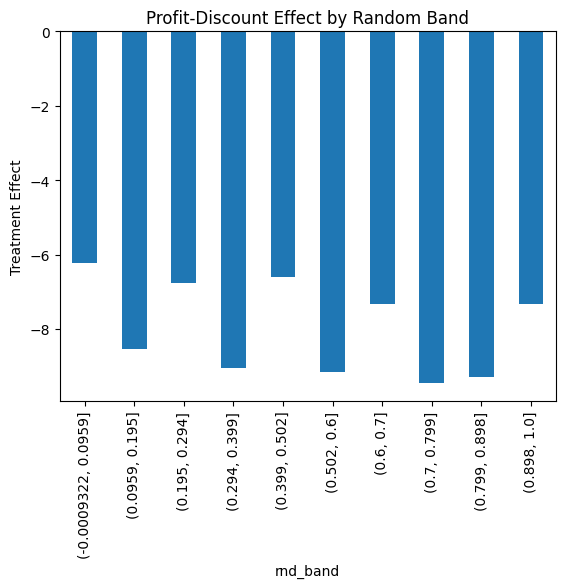

In [ ]:
np.random.seed(123)
(te_by_segment(test_pred.assign(rnd=np.random.uniform(0,1,test.shape[0])),
               "rnd", y="profit", t="binary_discount", segments=10)
 .plot.bar(title="Profit-Discount Effect by Random Band"))
plt.ylabel("Treatment Effect");

### Build a cumulative treatment effect plot to evaluate our model

 The idea is that if you have a score or a feature (such as age) that is good for segmentation, this score or feature will order customers from smallest to highest treatment effect. In the cumulative effect plot, you first sort customers by this segmentation score, then you estimate the treatment effect for the top 10% of customers with the highest treatment effect according to your score. Next, you estimate the TE of the top 20%, then the next 30%, and so on.

In [ ]:
def cumulative_elast_curve(dataset, prediction, y, t, steps=100, ascending=False):
    size = dataset.shape[0]
    ordered_df = dataset.sort_values(prediction, ascending=ascending).reset_index(drop=True) #order
    return np.array([te(ordered_df.query(f"index<={row}"), t=t, y=y)
                     for row in range(size//steps, size+1, size//steps)]) #in pieces and estiate treatment effect

Is it better to segment customers by the ML model prediction, by age, or simply at random?

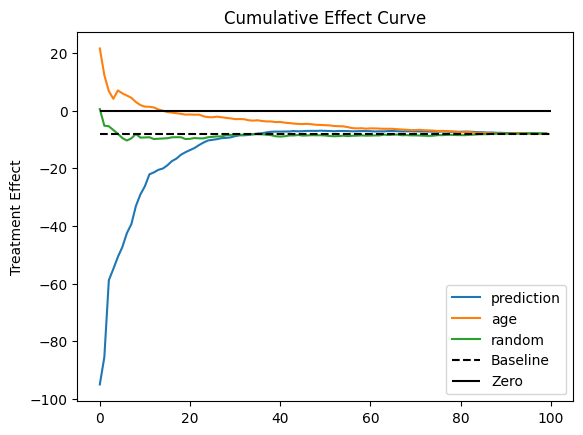

In [ ]:
cum_effect_prediction = cumulative_elast_curve(test_pred, "prediction", y="profit", t="binary_discount")
cum_effect_age = cumulative_elast_curve(test_pred, "age", y="profit", t="binary_discount")
cum_effect_rnd = cumulative_elast_curve(test_pred.assign(rnd=np.random.uniform(0, 1, test.shape[0])),
                                    "rnd", y="profit", t="binary_discount")

plt.plot(cum_effect_prediction, label="prediction")
plt.plot(cum_effect_age, label="age")
plt.plot(cum_effect_rnd, label="random")

plt.hlines(ate, 0, 100, linestyle="--", color="black", label="Baseline")
plt.hlines(0, 0, 100, linestyle="solid", color="black", label="Zero")
plt.ylabel("Treatment Effect")
plt.title("Cumulative Effect Curve")
plt.legend();

The cumulative effect curve tells a similar story from the one we've seen before, in the effect by segment step. Ordering customers by sales prediction will always yield treatment effects below the zero line. However, if we look by age, we can see that the top 20% older customers have a positive discount effect on profit.** This tells us that simply segmenting customers by age and sending discounts to older customers **is a better personalisation strategy than a complex ML model.

In the black dotted line, I've also shown the average treatment effect to see what would happen if we were to not segment at all. Since this line is below zero, it means that, on average, without personalising, discounts are not profitable. Also, notice how the random segmentation fluctuates around the ATE, as expected.


Cumulative Gain Curve:

Going from the cumulative effect plot (in the previous step) to the cumulative gain is actually very simple. All we have to do is multiply everything by the propositional sample size.

A random personalization score should start at zero and accumulate up linearly to the ATE. The bigger the area between the curve from a personalization score and the curve from a random score, the better the score is at personalization. This curve is similar in concept to the ROC curve that is already very famous in data science. Now let’s implement it.



In [ ]:
def cumulative_gain(dataset, prediction, y, t, steps=100, ascending=False):
    size = dataset.shape[0]
    ordered_df = dataset.sort_values(prediction, ascending=ascending).reset_index(drop=True)
    return np.array([te(ordered_df.query(f"index<={row}"), t=t, y=y)*row/size
                     for row in range(size//steps, size+1, size//steps)])


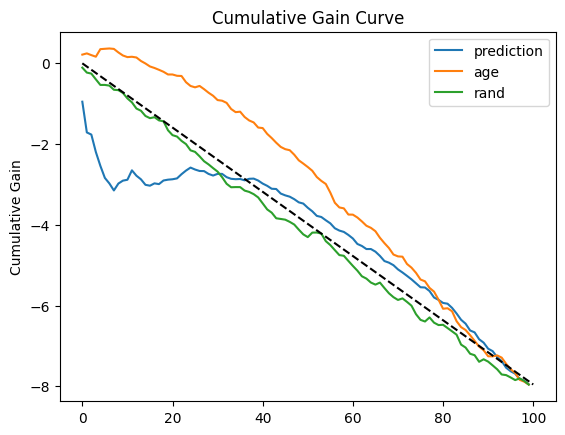

In [ ]:
np.random.seed(123)

gain_prediction = cumulative_gain(test_pred, "prediction", y="profit", t="binary_discount")
gain_age = cumulative_gain(test_pred, "age", y="profit", t="binary_discount")
gain_rand = cumulative_gain(test_pred.assign(rand=np.random.uniform(0, 1, test.shape[0])),
                            "rand", y="profit", t="binary_discount")

plt.plot(gain_prediction, label="prediction")
plt.plot(gain_age, label="age")
plt.plot(gain_rand, label="rand")

plt.plot([0, 100], [0, ate], linestyle="--", color="black")


plt.ylabel("Cumulative Gain")
plt.title("Cumulative Gain Curve")
plt.legend();

The cumulative gain tells a similar story. This curve is harder to interpret but it's the most convenient one to compare different strategies. The higher the curve (more to the top right corner), the better the personalisation strategy. Looking at it, we can clearly see that personalising by age is a much better idea than personalising by a ML model that predicts sales.

Again, the random model fluctuates around the baseline.

# Continuous Treatments


 In the binary treatment, if the treatment is randomly assigned (which it is in this case) we know that the TE is simply a difference in averages.


E[Y∣T=1]−E[Y∣T=0]

This quantity tells us how much the outcome increases as we flip the treatment from 0 to 1.

In the continuous case, we can think about the treatment effect as the linear coefficient from the regression line:


 $Y_i= α+τ T_i +e_i$

This coefficient tells us how much we should expect the outcome to increase if we increase the treatment by one unit

if we have a good personalization score, each segment will have very different slopes:

In [ ]:
def elast_by_segment(df, pred, y, t, segments=10):
  #computes the treatment effect (slope of the regression line) by any segment you define.
    return (df
            .assign(**{f"{pred}_band":pd.qcut(df[pred], q=segments)}) # makes quantile partitions
            .groupby(f"{pred}_band")
            .apply(lambda df: elast(df, y=y, t=t))) # estimate the elasticity on each partition

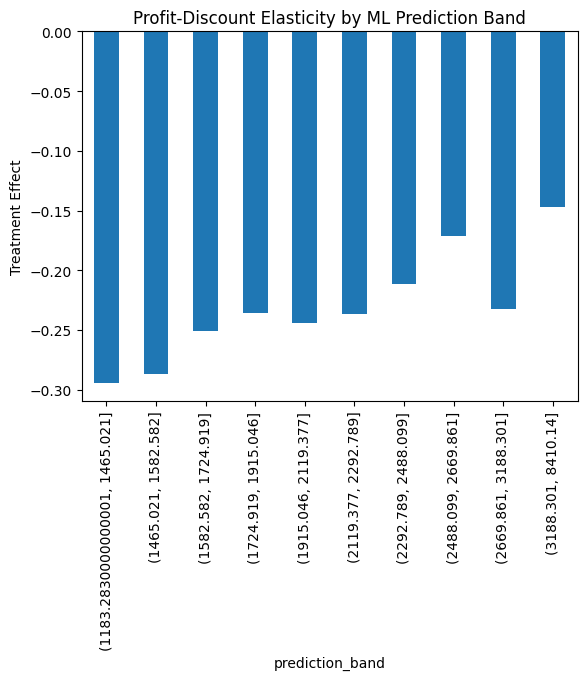

In [ ]:
(elast_by_segment(test_pred, "prediction", y="profit", t="discount", segments=10)
 .plot.bar(title="Profit-Discount Elasticity by ML Prediction Band"))
plt.ylabel("Treatment Effect");

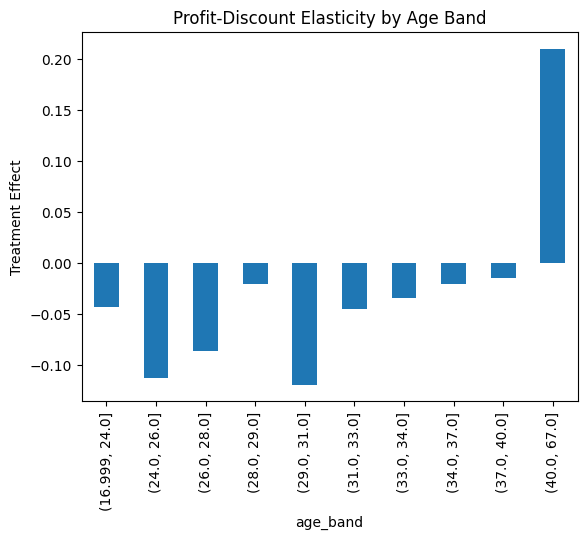

In [ ]:
(elast_by_segment(test_pred, "age", y="profit", t="discount", segments=10)
 .plot.bar(title="Profit-Discount Elasticity by Age Band"));
plt.ylabel(ylabel="Treatment Effect");

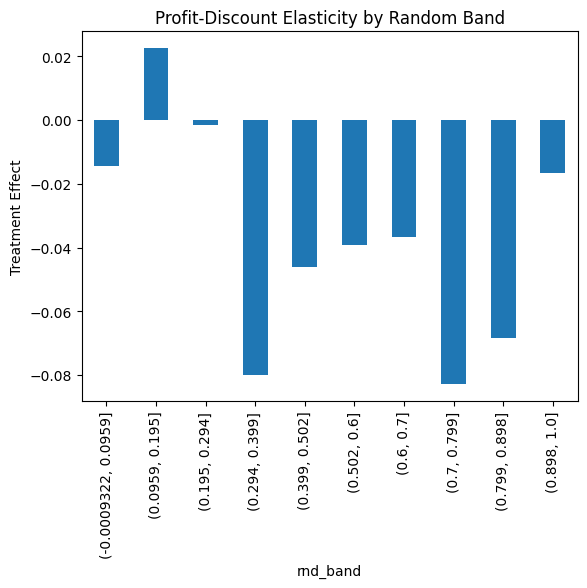

In [ ]:
np.random.seed(123)
(elast_by_segment(test_pred.assign(rnd=np.random.uniform(0,1,test.shape[0])),
                  "rnd", y="profit", t="discount", segments=10)
 .plot.bar(title="Profit-Discount Elasticity by Random Band"))
plt.ylabel("Treatment Effect");

If we segment the customers by our sales prediction model, we can see that, first, there is no segment where more discounts leads to more profit. Second, the higher the sales prediction, the less profit suffers from more discount. In other words, the treatment effect becomes less negative as sales prediction increases

Now, take a look at the age segments. First thing we notice is that there is an age segment where discounts are profitable. If we look at segment (40 to 67), we should expect profit to **increase** \\\$0.2 for every \\\$1.0 invested in discount (remember that \\(Profit = 0.5 Sales - Discount\\), so every \\\$1 spend will generate \\\$1.2 in revenues and hence, \\\$0.2 in profits). This means that, if we segment customers by age, we can find segments where discounts are profitable, something we cannot find with sales prediction segments.

Finally, once we segment by a random number, we can see that the treatment effect varies from positive to negative, but always very small numbers. This is probably noise, since in theory, the treatment effect of a random segment should match the ATE, which we know is negative.


In [ ]:
def cumulative_elast_curve(dataset, prediction, y, t, steps=100, ascending=False):
    size = dataset.shape[0]
    ordered_df = dataset.sort_values(prediction, ascending=ascending).reset_index(drop=True)
    return np.array([elast(ordered_df.query(f"index<={row}"), t=t, y=y)
                     for row in range(size//steps, size+1, size//steps)])




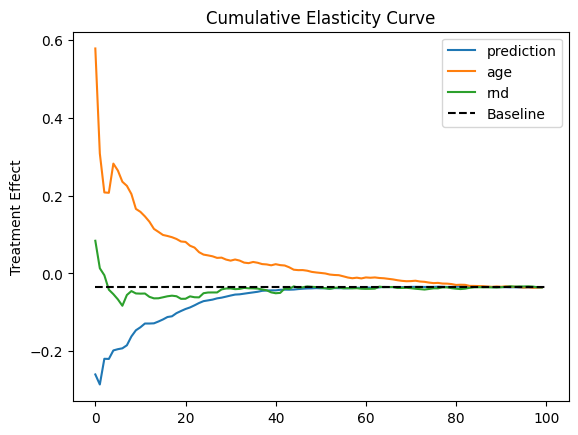

In [ ]:
cum_elast_prediction = cumulative_elast_curve(test_pred, "prediction", y="profit", t="discount")
cum_elast_age = cumulative_elast_curve(test_pred, "age", y="profit", t="discount")
cum_elast_rnd = cumulative_elast_curve(test_pred.assign(rnd=np.random.uniform(0, 1, test.shape[0])),
                                       "rnd", y="profit", t="discount")

plt.plot(cum_elast_prediction, label="prediction")
plt.plot(cum_elast_age, label="age")
plt.plot(cum_elast_rnd, label="rnd")

plt.hlines(elast(test_pred, "discount", "profit"), 0, 100, linestyle="--", color="black", label="Baseline")
plt.ylabel("Treatment Effect")
plt.title("Cumulative Elasticity Curve")
plt.legend();

The cumulative elasticity curve tells a similar story from the one we've seen before. Ordering customers by sales prediction will only always yield treatment effects below the zero line. However, if we look by age, we can see that the top 40% older customers have a positive discount effect on profit. This tells us that simply segmenting customers by age and sending discounts to older customers is a better personalisation strategy than a complex ML model.

In the black dotted line, I've also shown the average elasticity to see what would happen if we were to not segment at all. Since this line is below zero, it means that, on average, without personalising, discounts are not profitable. Also, notice how the random segmentation fluctuates around the ATE, as expected.

In [ ]:
def cumulative_gain(dataset, prediction, y, t, min_periods=30, steps=100, ascending=False):
    size = dataset.shape[0]
    ordered_df = dataset.sort_values(prediction, ascending=ascending).reset_index(drop=True)
    return np.array([elast(ordered_df.query(f"index<={row}"), t=t, y=y) * (row/size)
                     for row in range(size//steps, size+1, size//steps)])


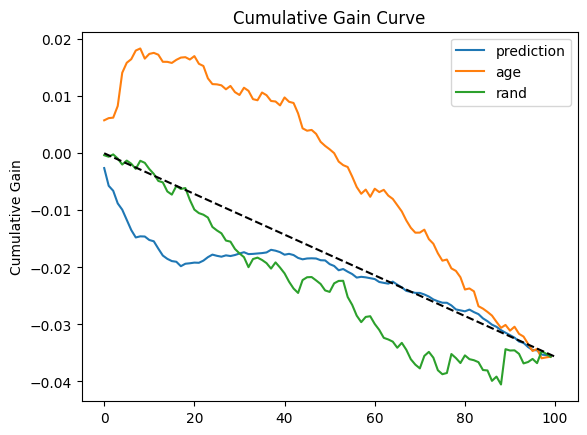

In [ ]:
np.random.seed(123)
gain_prediction = cumulative_gain(test_pred, "prediction", y="profit", t="discount", ascending=False)
gain_age = cumulative_gain(test_pred, "age", y="profit", t="discount", ascending=False)
gain_rand = cumulative_gain(test_pred.assign(rand=np.random.uniform(0, 1, test.shape[0])),
                            "rand", y="profit", t="discount", ascending=False)

plt.plot(gain_prediction, label="prediction")
plt.plot(gain_age, label="age")
plt.plot(gain_rand, label="rand")

plt.plot([0, 100], [0, elast(test_pred, "discount", "profit")], linestyle="--", color="black")


plt.ylabel("Cumulative Gain")
plt.title("Cumulative Gain Curve")
plt.legend();

The cumulative gain tells a similar story. This curve is harder to interpret but it's the most convenient one to compare different strategies. The higher the curve (more to the top right corner), the better the personalisation strategy. Looking at it, we can clearly see that personalising by age is a much better idea than personalising by a ML model that predicts sales.

Again, the random model fluctuates around the baseline.

The Elasticity or TE by Band plots shows that the model orders the treatment effect nicely, even in a dataset which it didn't see during the fitting process. As we can see, customers with high TE prediction indeed have high TE in the data where discount was randomized. Also, customers with low TE prediction have, indeed, low TE.

The cumulative elasticity curve shows that our TE model starts further from the ATE and converges slowlier to it. This means that the model is better at distinguishing customers with high TE from those with low TE. It's better than simply using Age, but not by much. The cumulative gain plot shows a similar picture, with our model coming on top once again.

# Causal Model for Personalization


Remember that a great personalization strategy will find some way to segment the customers in such a way that they respond very differently to the treatment in each segment. Another way of saying this is that we want to find some score in such a way that if we order customers by this score, the top customers will have a very high treatment effect (sensitivity to discount), while the bottom customer will have a very low treatment effect (probably negative sensitivity to discount). Now, how can we go about crafting such a score?

There are actually multiple ways. Some very good ones involve machine learning, but that’s a topic for another project. Here we will use a very simple strategy. First, remember that if we have randomized data, then we can use linear regression to estimate the effect of discount on profits:

$Profit_i = β_0 +β_1 Discount_i + e_i$

Here  $β_1$ is the regression coefficient, can be viewed as the treatment effect (since the discount was randomly assigned). What happens if we add Age to this model and also include an interaction between age and discount?
$Profit_i = β_0 +β_1 Age_i + β_2 Discount_i + β_3 Discount_i Age_i+ e_i$

Now the treatment effect is no longer just the coefficient associated with the discount. The treatment effect will change, depending on age


In [ ]:
# On the training data (nonrandom data), fit a linear regression that interacts discount with tenure, age, and cust_state.
teh_model = smf.ols("profit~discount*(tenure+age+C(cust_state))", data=train).fit()

In [ ]:
#We now need to extract the treatment effect prediction from this model. One way of doing that is finding the
#parameters associated with the interaction and multiplying them by the values of tenure, age, and cust_state
# (or make profit predictions in the test data, substract.1 from the discounts given and make the predictions again)

test_te = teh_model.predict(test) - teh_model.predict(test.assign(discount=test["discount"]-1))

test_pred["teh_model"] = test_te

The Elasticity or TE by Band plots shows that the model orders the treatment effect nicely, even in a dataset which it didn't see during the fitting process. As we can see, customers with high TE prediction indeed have high TE in the data where discount was randomized. Also, customers with low TE prediction have, indeed, low TE.

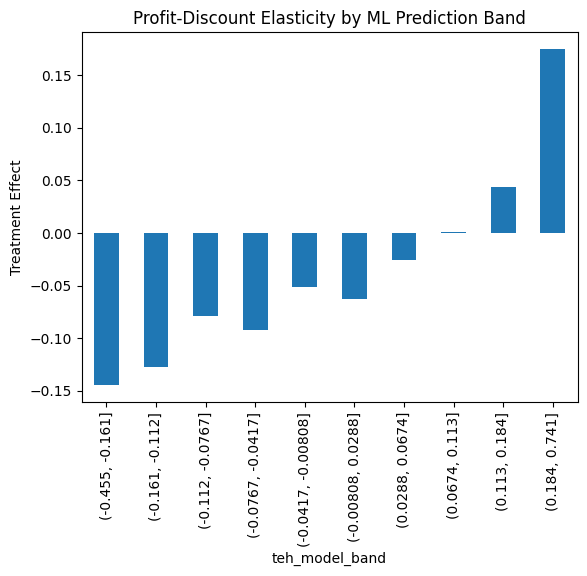

In [ ]:
(elast_by_segment(test_pred, "teh_model", y="profit", t="discount", segments=10)
 .plot.bar(title="Profit-Discount Elasticity by ML Prediction Band"))
plt.ylabel("Treatment Effect");


The cumulative elasticity curve shows that our TE model starts further from the ATE and converges slowlier to it. This means that the model is better at distinguishing customers with high TE from those with low TE. It's better than simply using Age, but not by much. The cumulative gain plot shows a similar picture, with our model coming on top once again.

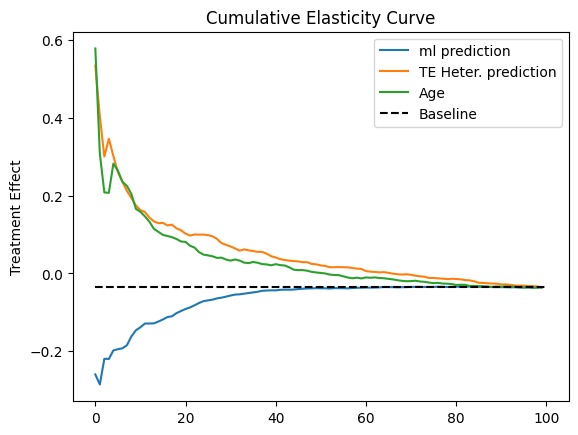

In [ ]:
cum_elast_teh = cumulative_elast_curve(test_pred, "teh_model", y="profit", t="discount")

plt.plot(cum_elast_prediction, label="ml prediction")
plt.plot(cum_elast_teh, label="TE Heter. prediction")
plt.plot(cum_elast_age, label="Age")

plt.hlines(elast(test_pred, "discount", "profit"), 0, 100, linestyle="--", color="black", label="Baseline")
plt.ylabel("Treatment Effect")
plt.title("Cumulative Elasticity Curve")
plt.legend();

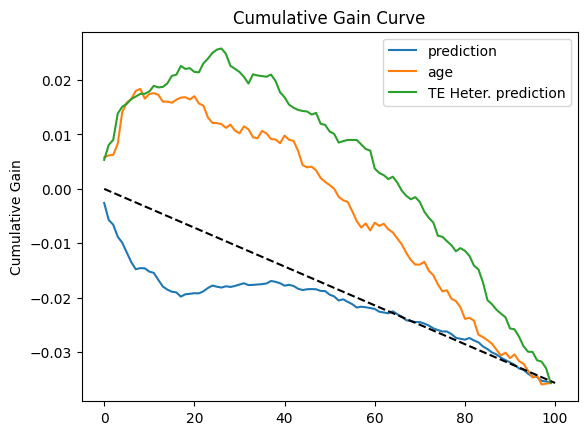

In [ ]:
gain_teh = cumulative_gain(test_pred, "teh_model", y="profit", t="discount", ascending=False)

plt.plot(gain_prediction, label="prediction")
plt.plot(gain_age, label="age")
plt.plot(gain_teh, label="TE Heter. prediction")

plt.plot([0, 100], [0, elast(test_pred, "discount", "profit")], linestyle="--", color="black")

plt.ylabel("Cumulative Gain")
plt.title("Cumulative Gain Curve")
plt.legend();